In [19]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

from utils import *
from losses import *


import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)           

In [116]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs = 1000
logf = (nepochs//10) + 1                        
learning_rate = 2e-3                                       
device = set_device("cuda", 0)

No GPU available! Running on CPU


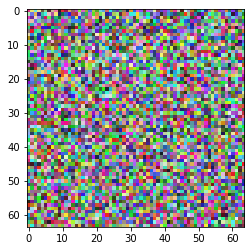

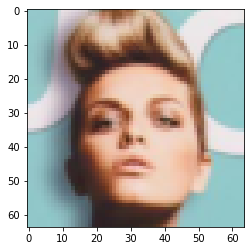

In [117]:
img_dim = 64
ds = ImageFolder(root="/home/dp4018/scripts/AWLoss/examples/data/celeba/",
                               transform=Compose([
                               Resize(img_dim),
                               CenterCrop(img_dim),
                               ToTensor()]))

imgA, imgB = ds[5][0], ds[4][0]

imgA = scale2range(torch.rand_like(imgA), [imgB.min(), imgB.max()])

plt.imshow(imgA.permute(1, 2, 0))
plt.show()

plt.imshow(imgB.permute(1, 2, 0))
plt.show()


In [118]:
imgA = torch.tensor(imgA, requires_grad=True).to(device)
imgB = torch.tensor(imgB, requires_grad=True).to(device)

/tmp/ipykernel_3376306/1499201202.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgA = torch.tensor(imgA, requires_grad=True).to(device)
/tmp/ipykernel_3376306/1499201202.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgB = torch.tensor(imgB, requires_grad=True).to(device)


In [119]:
def train(imgA, imgB, criterion, nepochs=100, logf=10):
    for n in range(nepochs):
        loss = criterion(imgA, imgB)
        loss.backward()
        optimizer.step()

        if n % logf == 0 or n == nepochs-1:
            print("epoch %d loss %.2f"%(n, loss.item()))

/tmp/ipykernel_3376306/3872402150.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgA_to_optim = torch.tensor(imgA_to_optim, requires_grad=True).to(device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 0 loss 1670.73
epoch 25 loss 1308.50
epoch 50 loss 951.25
epoch 75 loss 655.93
epoch 100 loss 439.60
epoch 125 loss 296.61
epoch 150 loss 215.25
epoch 175 loss 183.88
epoch 200 loss 190.14
epoch 225 loss 223.65
epoch 249 loss 272.93


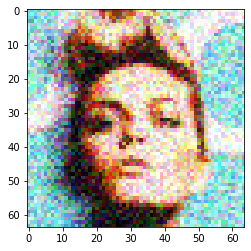

In [121]:
imgA_to_optim = imgA.clone()
imgA_to_optim = torch.tensor(imgA_to_optim, requires_grad=True).to(device)

optimizer = torch.optim.Adam([imgA_to_optim], lr=learning_rate)
mseloss = nn.MSELoss(reduction="sum")

train(imgA_to_optim, imgB, mseloss, nepochs=250, logf=25)

plt.imshow(imgA_to_optim.permute(1, 2, 0).detach().numpy())
plt.show()

/tmp/ipykernel_3376306/2765364554.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgA_to_optim = torch.tensor(imgA_to_optim, requires_grad=True).to(device)


epoch 0 loss 1.50
epoch 101 loss 1.48
epoch 202 loss 1.48
epoch 303 loss 1.46
epoch 404 loss 1.47
epoch 505 loss 1.45
epoch 606 loss 1.44
epoch 707 loss 1.44
epoch 808 loss 1.43
epoch 909 loss 1.42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 999 loss 1.43


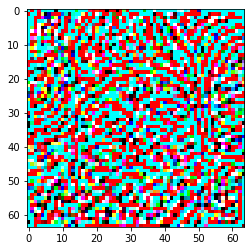

In [124]:
imgA_to_optim = imgA.clone()
imgA_to_optim = torch.tensor(imgA_to_optim, requires_grad=True).to(device)

optimizer = torch.optim.Adam([imgA_to_optim], lr=learning_rate)
awloss = AWLoss(filter_dim=2,  std=3e-8, epsilon=10., gamma=1e-4, eta=0., filter_scale=2, 
                    reduction="sum", method="fft", store_filters=False)

train(imgA_to_optim.unsqueeze(0), imgB.unsqueeze(0), awloss, nepochs, logf)

plt.imshow(imgA_to_optim.permute(1, 2, 0).detach().numpy())
plt.show()

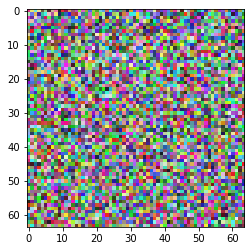

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


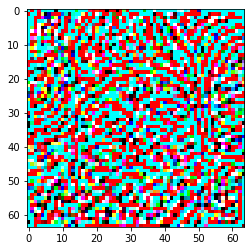

In [127]:
plt.imshow(imgA.permute(1, 2 , 0).detach().numpy())
plt.show()
plt.imshow(imgA_to_optim.permute(1, 2, 0).detach().numpy())
plt.show()